In [0]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyflux as pf
%matplotlib inline

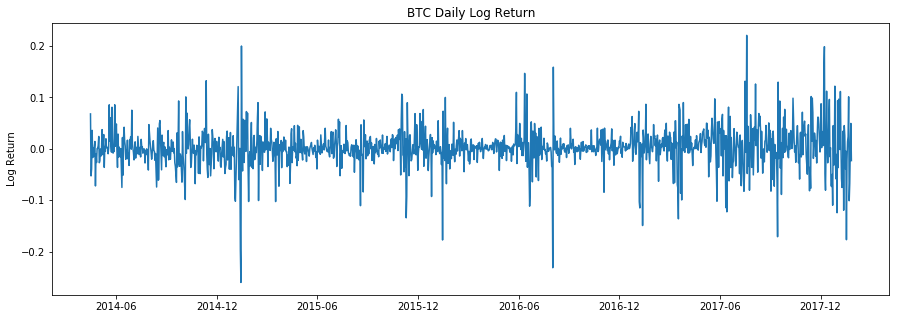

In [0]:
btc_df = quandl.get("BITSTAMP/USD", authtoken="HBdbdzczsM-uS6BNxroQ") #2014-04-15 to current

'''Using daily closing price of BTC to USD, calculate daily logarithmic returns
Saves percentage change from yesterday in column pct_change, and saves logarithmic
returns in column log_return'''

btc_df['pct_change'] = btc_df['Last'].pct_change()
btc_df['log_return'] = np.log(1 + btc_df['pct_change'])
btc_df.drop(btc_df.index[0], inplace=True) #drop first row because of n/a log_return value

log_return_btc_df = btc_df[["log_return"]]#save log_returns column to its own dataframe

plt.figure(figsize=(15,5))
plt.plot(btc_df.index,btc_df['log_return'])
plt.ylabel('Log Return')
plt.title('BTC Daily Log Return');

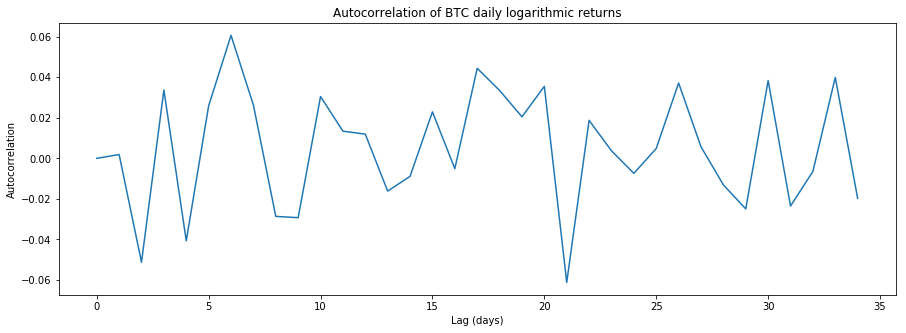

In [0]:
'''Autocorrelation of btc log returns:'''
log_return_btc = btc_df['log_return']
auto_corr_btc_returns = np.zeros(shape=35)
#print("autocorrelation coefficients for BTC daily logarithmic returns:")
for N in range(1,35):
    auto_corr_btc_return = log_return_btc.autocorr(lag=N)
    auto_corr_btc_returns[N] = auto_corr_btc_return

plt.figure(figsize=(15,5))
plt.plot(auto_corr_btc_returns)
plt.ylabel('Autocorrelation')
plt.xlabel('Lag (days)')
plt.title('Autocorrelation of BTC daily logarithmic returns');

In [0]:
log_return_btc_df = btc_df[["log_return"]]

Normal ARIMA(4,0,4)                                                                                       
======================================================= ==================================================
Dependent Variable: log_return                          Method: MLE                                       
Start Date: 2014-04-20 00:00:00                         Log Likelihood: 2504.3077                         
End Date: 2018-01-26 00:00:00                           AIC: -4988.6155                                   
Number of observations: 1359                            BIC: -4936.4704                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0049     0.0024     2.0119   0.0442   (0.0001 | 0.0097)        
AR(1)                                

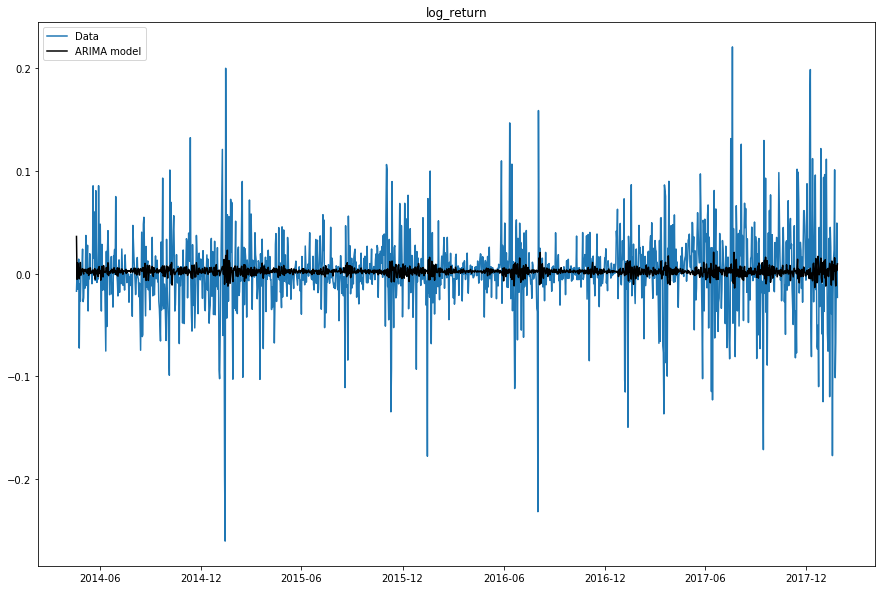

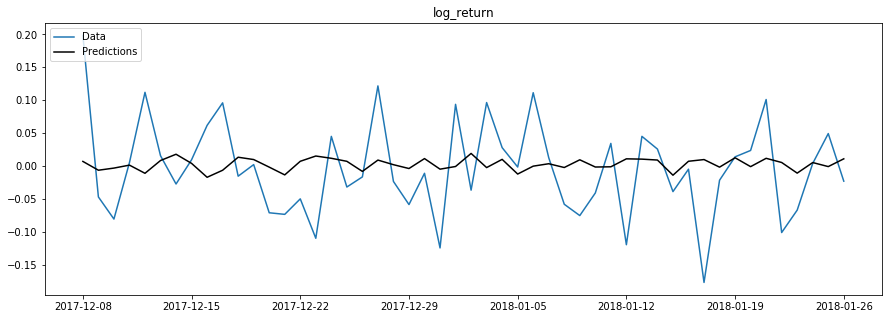

In [0]:
arima_model = pf.ARIMA(data=log_return_btc_df, ar=4, ma=4, integ=0, target='log_return')
x = arima_model.fit(method='MLE')
x.summary()
arima_model.plot_fit(figsize=(15,10))
arima_model.plot_predict_is(h=50, figsize=(15,5))

In [0]:
garch_model = pf.GARCH(p=1, q=1, data=log_return_btc_df)
print(garch_model.latent_variables)
garch_model.adjust_prior(1, pf.TruncatedNormal(0.01, 0.5, lower=0.0, upper=1.0))
garch_model.adjust_prior(2, pf.TruncatedNormal(0.97, 0.5, lower=0.0, upper=1.0))

Index    Latent Variable           Prior           Prior Hyperparameters     V.I. Dist  Transform 
======== ========================= =============== ========================= ========== ==========
0        Vol Constant              Normal          mu0: 0, sigma0: 3         Normal     exp       
1        q(1)                      Normal          mu0: 0, sigma0: 0.5       Normal     logit     
2        p(1)                      Normal          mu0: 0, sigma0: 0.5       Normal     logit     
3        Returns Constant          Normal          mu0: 0, sigma0: 3         Normal     None      


Acceptance rate of Metropolis-Hastings is 0.000175
Acceptance rate of Metropolis-Hastings is 0.0011
Acceptance rate of Metropolis-Hastings is 0.0566
Acceptance rate of Metropolis-Hastings is 0.1898
Acceptance rate of Metropolis-Hastings is 0.244825

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2382


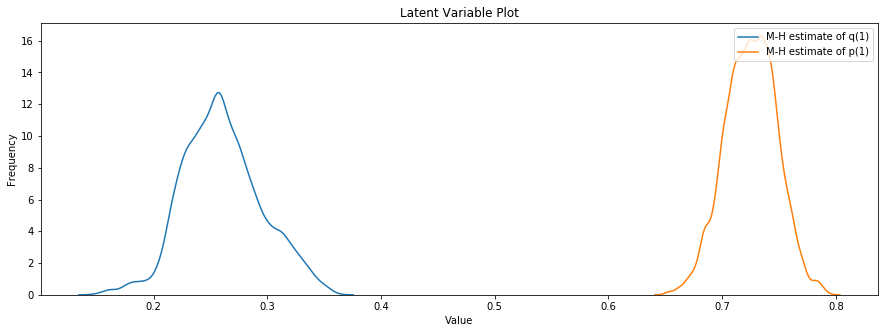

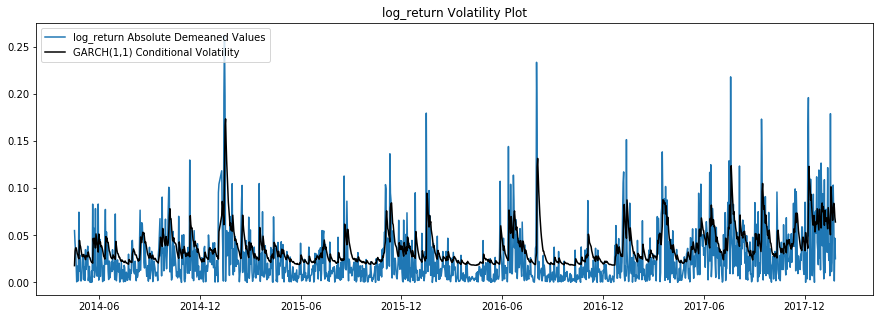

In [0]:
result = garch_model.fit('M-H', nsims=20000)
garch_model.plot_z([1,2])
garch_model.plot_fit(figsize=(15,5))

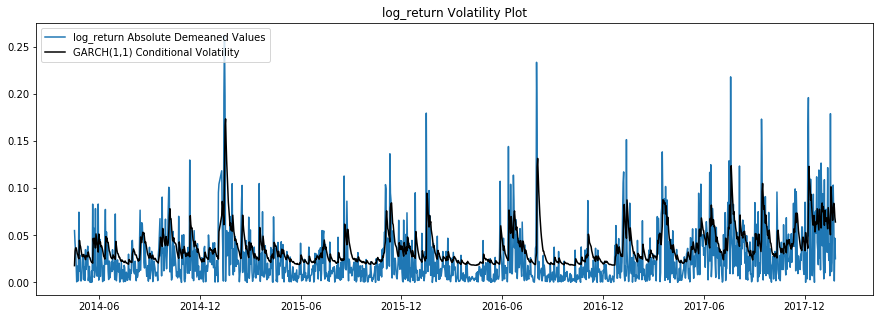

In [0]:
garch_model.plot_fit(figsize=(15,5))

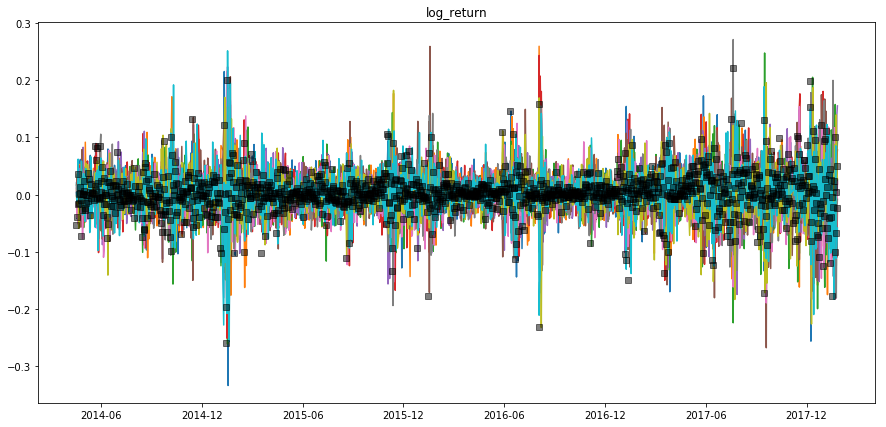

In [0]:
garch_model.plot_sample(nsims=10, figsize=(15,7))

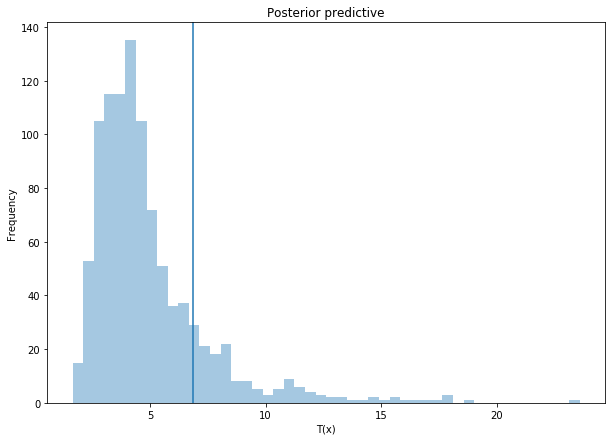

In [0]:
from scipy.stats import kurtosis
garch_model.plot_ppc(T=kurtosis)

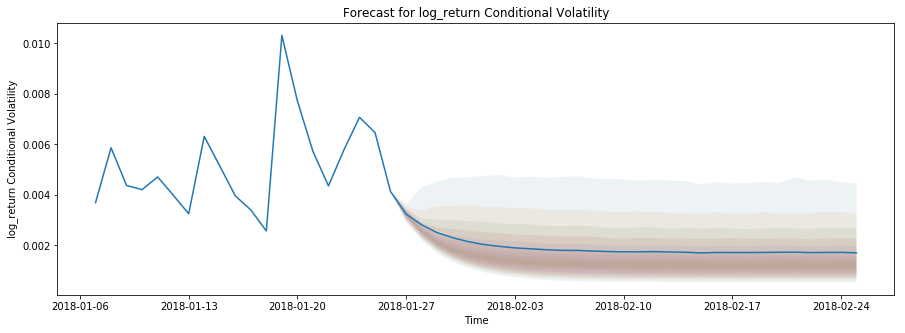

In [0]:
garch_model.plot_predict(h=30, figsize=(15,5))

In [0]:
lme_garch_model = pf.LMEGARCH(log_return_btc_df,p=1,q=1)
x = lme_garch_model.fit()
x.summary()

LMEGARCH(1,1)                                                                                             
======================================================= ==================================================
Dependent Variable: log_return                          Method: MLE                                       
Start Date: 2014-04-17 00:00:00                         Log Likelihood: 2884.2249                         
End Date: 2018-01-26 00:00:00                           AIC: -5754.4499                                   
Number of observations: 1362                            BIC: -5717.9329                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             -7.0459    0.4823     -14.6097 0.0      (-7.9912 | -6.1007)      
Component 1 p(1)                     

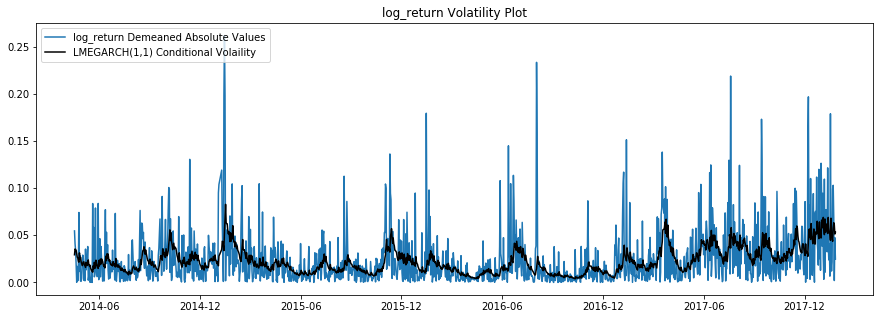

In [0]:
lme_garch_model.plot_fit(figsize=(15,5))

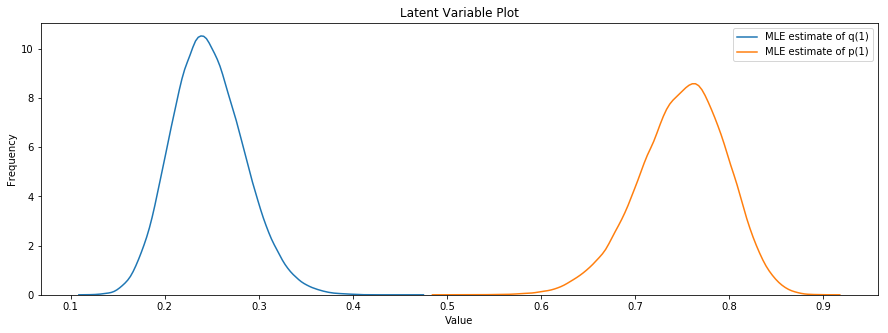

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: log_return                          Method: MLE                                       
Start Date: 2014-04-17 00:00:00                         Log Likelihood: 2706.7739                         
End Date: 2018-01-26 00:00:00                           AIC: -5405.5477                                   
Number of observations: 1362                            BIC: -5384.6809                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             0.0001                                                           
q(1)                                 

In [0]:
garch_model = pf.GARCH(p=1, q=1, data=log_return_btc_df)
result = garch_model.fit()
garch_model.plot_z([1,2])
result.summary()

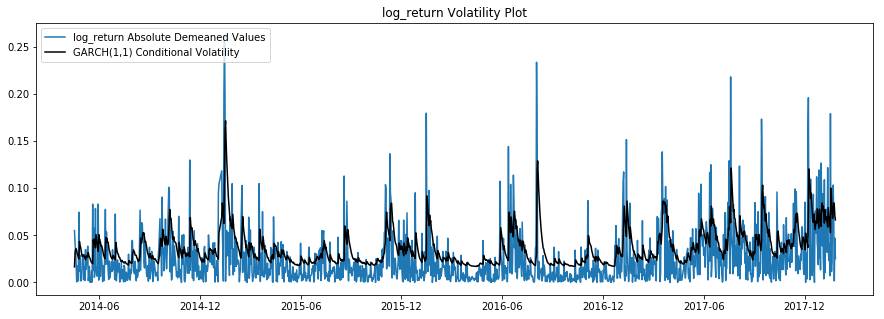

In [0]:
garch_model.plot_fit(figsize=(15,5))

In [0]:
# garch_model.plot_sample(nsims=10, figsize=(15,7))

In [0]:
# from scipy.stats import kurtosis
# garch_model.plot_ppc(T=kurtosis)

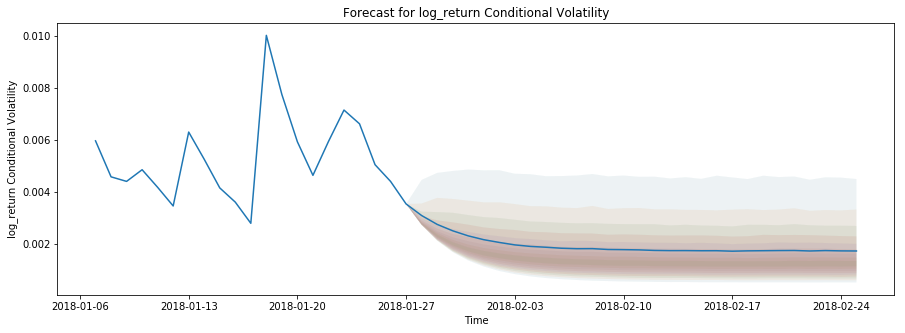

In [0]:
garch_model.plot_predict(h=30, figsize=(15,5))

In [0]:
egarch_model = pf.EGARCH(log_return_btc_df,p=1,q=1)
x = egarch_model.fit()
x.summary()

EGARCH(1,1)                                                                                               
======================================================= ==================================================
Dependent Variable: log_return                          Method: MLE                                       
Start Date: 2014-04-17 00:00:00                         Log Likelihood: 2892.2732                         
End Date: 2018-01-26 00:00:00                           AIC: -5774.5465                                   
Number of observations: 1362                            BIC: -5748.4629                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             -0.2407    0.0271     -8.8744  0.0      (-0.2939 | -0.1875)      
p(1)                                 

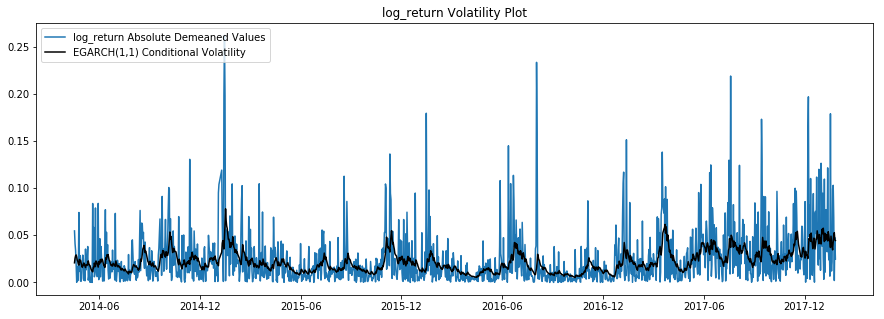

In [0]:
egarch_model.plot_fit(figsize=(15,5))

NGARCH